<a href="https://colab.research.google.com/github/1900690/Titanic-Analysis/blob/main/SHAP-importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SHAP Importance

[決定木ベースの機械学習手法](https://qiita.com/ameshikou/items/093d86dd46b4d440deae#:~:text=%E3%81%A8%E5%AC%89%E3%81%97%E3%81%84%E3%81%A7%E3%81%99%EF%BC%81-,%E6%B1%BA%E5%AE%9A%E6%9C%A8%E3%83%99%E3%83%BC%E3%82%B9%E3%81%AE%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E6%89%8B%E6%B3%95,-%E3%81%BE%E3%81%9A%E3%81%AF%E3%81%9D%E3%82%82%E3%81%9D%E3%82%82%E3%80%8C%E6%B1%BA%E5%AE%9A)において、結果の解釈指標となるSHAP値の算出方法とその結果の解釈方法

SHAPは「予測用データと学習済みモデル」を用いて、特徴量ごとに算出される値です。
モデルが予測値の算出に大きく寄与するような（モデルの出力を大きく変化させるような）特徴量を表現できます。








In [1]:
#@title  1. 必要なライブラリをすべてインポートする
# Google Colabでは、まずSHAPライブラリをインストールする必要があります。
!pip -q install shap
# 日本語ライブラリをインポート
!pip -q install japanize-matplotlib

#SHAPライブラリを使用して、シャープレイ値の推定と視覚化を行う。
import shap

# xgboostライブラリのXGBoost実装を使用する。
import xgboost

# Scikit-learnライブラリの次の関数を使用して、データセットをトレーニングデータセットとテストデータセットに分割します。
from sklearn.model_selection import train_test_split

#モデルの予測値の平均二乗誤差を計算するために、Scikit-learnライブラリの次の関数を使用します。
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# 2. サンプル・データセットをロードする

カリフォルニア住宅データセットをロードする (https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)

In [4]:
# カリフォルニア住宅価格データセットを読み込む
california = fetch_california_housing()

# データをDataFrameに変換
df = pd.DataFrame(california.data, columns=california.feature_names)

# カラム名を日本語に変更
japanese_columns = {
    'MedInc': '世帯の中央値収入',
    'HouseAge': '住宅の築年数',
    'AveRooms': '平均部屋数',
    'AveBedrms': '平均寝室数',
    'Population': '人口',
    'AveOccup': '世帯の平均人数',
    'Latitude': '緯度',
    'Longitude': '経度',
}
df.rename(columns=japanese_columns, inplace=True)
df['住宅価格'] = california.target

# 特徴量とターゲットに分ける
X = df.drop('住宅価格', axis=1)
y = df['住宅価格']

データセットをトレーニング用データセットとテスト用データセットに分割し、トレーニング用データセットには80%のインスタンスを、テスト用データセットには20%のインスタンスを使用する。

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
X_train

,世帯の中央値収入,住宅の築年数,平均部屋数,平均寝室数,人口,世帯の平均人数,緯度,経度
12069,4.2386,6.0,7.723077,1.169231,228.0,3.507692,33.83,-117.55
15925,4.3898,52.0,5.326622,1.100671,1485.0,3.322148,37.73,-122.44
11162,3.9333,26.0,4.668478,1.046196,1022.0,2.777174,33.83,-118.00
4904,1.4653,38.0,3.383495,1.009709,749.0,3.635922,34.01,-118.26
4683,3.1765,52.0,4.119792,1.043403,1135.0,1.970486,34.08,-118.36
...,...,...,...,...,...,...,...,...
13123,4.4125,20.0,6.000000,1.045662,712.0,3.251142,38.27,-121.26
19648,2.9135,27.0,5.349282,0.933014,647.0,3.095694,37.48,-120.89
9845,3.1977,31.0,3.641221,0.941476,704.0,1.791349,36.58,-121.90
10799,5.6315,34.0,4.540598,1.064103,1052.0,2.247863,33.62,-117.93


In [7]:
y_train

,住宅価格
12069,5.00001
15925,2.70000
11162,1.96100
4904,1.18800
4683,2.25000
...,...
13123,1.44600
19648,1.59400
9845,2.89300
10799,4.84600


# 3. XGBoostモデルをトレーニングする

回帰タスク用のXGBoostモデルを初期化する

In [9]:
model = xgboost.XGBRegressor()

トレーニングデータセットでXGBoostモデルをトレーニングする。

In [10]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

XGBoostモデルを使ってテストデータセットで予測を行う

In [11]:
predictions = model.predict(X_test)

平均二乗誤差を用いてテストデータセットの予測誤差を計算する。

In [12]:
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

MSE: 0.207833


# 4. SHAPライブラリを使ったXGBoostモデルの説明

## 4.1. シャープレイ値を推定する

SHAPを使ってシャプレー値を推定する説明器を初期化する。

ここでは、トレーニングデータセットX_trainを使って基本値を計算する

In [13]:
explainer = shap.Explainer(model=model, masker=X_train)

以下に示すように、Tree SHAPアルゴリズムがシャープレイ値の推定に使用されています。

Tree SHAPは、樹木モデルや樹木アンサンブルのために特別に設計された手法で、シャープレイ値を迅速かつ正確に推定します。

In [14]:
explainer.__class__

shap.explainers._tree.TreeExplainer

テストデータセットのシャープレイ値を推定する。

In [ ]:
shap_values = explainer(X_test)

 66%|=============       | 2722/4128 [00:36<00:18]       

## 4.2. Local Explanations

Local Explanationsとは、ブラックボックスモデルの予測を局所的に解釈し、どの特徴量がどの程度影響を与えたのかを説明する手法

### Waterfall Plot

waterfall plotを使って、テストデータセットの最初のインスタンスの予測のためのシャープレイ値を可視化します。

waterfall plotはshap_values.base_valuesからmodel.predict(X_test)[0]までの結果を示しています。

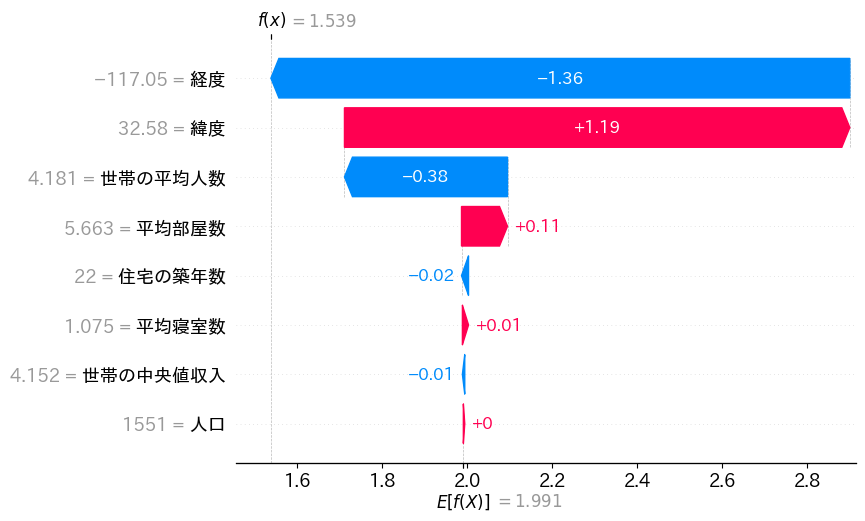

In [ ]:
shap.plots.waterfall(shap_values[0])

### Force Plot

force plotsを使用したビジュアライゼーションでは、Javascriptライブラリをロードする必要があります。

In [ ]:
shap.initjs()

force plotを用いて、テストデータセットの最初のインスタンスの予測に対するシャープレイ値を可視化する。

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0])

## 4.3. Global explanations

Global explanations は、モデルの全体的な挙動を説明する。

### Bar Plot

bar plotを使ってテストデータセット全体のシャープレイ値を可視化する。

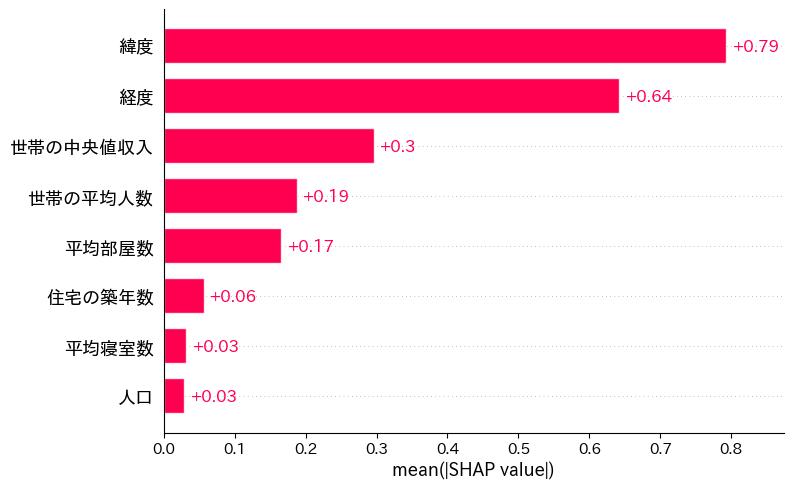

In [ ]:
shap.plots.bar(shap_values)

max_display パラメータを使用して、bar plotに表示するバーの最大数を設定できます。

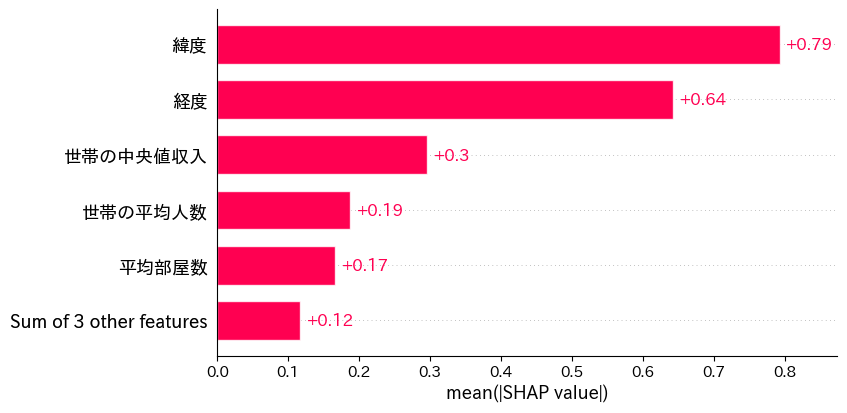

In [ ]:
shap.plots.bar(shap_values, max_display=6)

### Beeswarm Plot

テストデータセット全体のシャープレイ値をbeeswarm plotで可視化する。

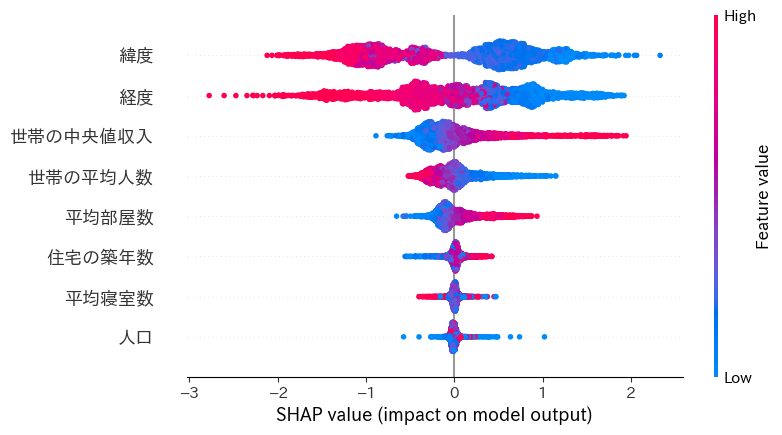

In [ ]:
shap.plots.beeswarm(shap_values)

### Force Plot

force plotを使用して、テストデータセット全体のシャープレイ値を可視化する。

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0:100])